Reference: https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/1_gcn.html#math

**Step 1: Import all the libraries required
(install if not already present)**

In [0]:
!pip install dgl

import networkx as nx
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

**Step 2: Load the Graph and specify input feature vectors, train_mask, test_mask and true labels**

In [0]:
# Graph can be loaded from networkx
G = nx.karate_club_graph()
# Store G to nx_graph, for later use (for finding square roots of degrees)
nx_graph = G

# labels will store true labels for each node.
labels = []
n = G.number_of_nodes()

# If the true community is "Mr. Hi" then 0 will be appended, otherwise 1 (for "Officer")
for node in range(n):
    if G.nodes[node]['club'] == "Mr. Hi":
        labels.append(0)
    else:
        labels.append(1)

# Make train_mask, which is a Boolean array in which True corresponds to the node which has to be taken in training set
# Similiarly make test_mask ( True corresponds to node which is to be taken in test set)

# As given in the question, nodes 0 and 33 are to be taken as training set, so for them train_mask will be True otherwise False
train_mask = [False for node in range(n)]
train_mask[0] = True
train_mask[33] = True

# Test_mask will be True for rest of the nodes and False for nodes 0 and 33
test_mask = [True for node in range(n)]
test_mask[0] = False
test_mask[33] = False

# Make the input feature array, which is a one-hot encoded array for all nodes
# 34x34 array will be made, as a one-hot encoded vector of size 34x1 will be stored for all 34 nodes.
features = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    features[i][i] = 1

# Convert the above mentioned variables to torch Tensors, to feed to the Neural Net
features = th.FloatTensor(features)
labels = th.LongTensor(labels)
train_mask = th.BoolTensor(train_mask)
test_mask = th.BoolTensor(test_mask)

# Convert the graph into a DGL graph object, so that it can be fed into the Neural Net
G = dgl.DGLGraph(G)

**Step 3: Specify the message and reduce function**

In [0]:
# Self-defined message and reduce functions incorporate normalization of the adjacency matrix, which was previously missing

# First, calculate the square roots of degrees of all nodes in the graph
# Create root_degrees as an empty torch tensor, and store roots of degrees in it
degrees = dict(nx_graph.degree(nx_graph.nodes()))
root_degrees = th.zeros([34],dtype=th.float32)
for node in degrees:
    root_degrees[node] = math.sqrt(degrees[node])

# Assign above tensor as degree feature to Graph (after reshaping so that dimension becomes 34x1)
G.ndata['deg'] = root_degrees.reshape(-1,1)

# Self defined message function is Edge UDF(user defined function), edges.src allows us to access the features of source node
def self_defined_message_function(edges):
    return {'m' : edges.src['h'] / edges.src['deg']} # The message passed is node embedding divided by degree square root

# Self defined reduce function is Node UDF, nodes.mailbox enables access to the incoming messages
# nodes.data enables access to node features
def self_defined_reduce_function(nodes):
    messages = th.sum(nodes.mailbox['m'],dim=1) # Messages are aggregated along the first dimension 
    msg =  messages / nodes.data['deg'] # The sum is divided by node degree root
    return {'h': messages} # The above value is assigned to node embedding

# The above self-defined functions are registered so that later they could be called on G.
G.register_message_func(self_defined_message_function)
G.register_reduce_func(self_defined_reduce_function)

**Step 4: Define the GCNLayer module and Neural Net architecture**

In [0]:
# GCNLayer module can be built upon torch.nn Module (designed to implement message passing)
class GCNLayer(nn.Module):
    
    # define the constructor, in which there is a linear layer to implement the linear transformation
    def __init__(self, in_features, out_features):
        super(GCNLayer,self).__init__()
        self.linear_layer = nn.Linear(in_features,out_features)

    def forward(self, G, features):
        with G.local_scope():  # Specify the local_scope, so that any changes outside this won't be reflected to the node features
            # Assign the input features to the nodes
            G.ndata['h'] = features
            # Update_all initiates the message passing paradigm i.e transfer and aggregation of messages from one node to another (using self defined message and reduce functions)
            G.update_all(self_defined_message_function,self_defined_reduce_function)
            # The resultant node features are returned, after going through the linear transformation through the linear_layer
            return self.linear_layer(G.ndata['h'])

# Neural_net consisting of two GCNLayer modules, to compute the final node embeddings
class Neural_Net(nn.Module):

    # Define the constructor
    def __init__(self):
        super(Neural_Net,self).__init__()
        self.layer1 = GCNLayer(34,16) # Input size is 34
        self.layer2 = GCNLayer(16,2) # Output size is 2 (due to 2 final classes)
    
    def forward(self, G, features):
        x = F.relu(self.layer1(G,features)) # Apply non-linearity to the output of first GCNlayer
        x = self.layer2(G,x) # Apply the second GCNLayer (this computes node embeddings, so no need of applying non-linearity)
        return x

**Step 5: Start the Training process**

In [7]:
net = Neural_Net()
optimizer = th.optim.Adam(net.parameters(), lr=1e-3) # Specify the optimizer (Adam) 
node_embeddings_at_timestamps = []

# Number of epochs = 200
for epoch in range(200):
    net.train()  # Start training
    logits = net(G,features)  # Obtain node_embeddings
    log_probabilities = F.log_softmax(logits,1) # Obtain the log_probabilities after passing through a log_softmax layer (required for nll loss)
    if epoch==10 or epoch==20 or epoch==40 or epoch==100 or epoch==180:  # Append node embeddings at epochs=10,20,40,100,180 to the node_embeddings_list 
        node_embeddings_at_timestamps.append(logits)

    # Negative log-likelihood loss is taken, pass the labels and log_probabilities(masked with train_mask) to the loss function.
    loss = F.nll_loss(log_probabilities[train_mask] , labels[train_mask])

    # Perform gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss and epoch
    print("Epoch: " + str(epoch) + " ; Loss function value: " + str(loss.item()))

Epoch: 0 ; Loss function value: 0.7233747243881226
Epoch: 1 ; Loss function value: 0.7123955488204956
Epoch: 2 ; Loss function value: 0.7018102407455444
Epoch: 3 ; Loss function value: 0.6915911436080933
Epoch: 4 ; Loss function value: 0.6817243099212646
Epoch: 5 ; Loss function value: 0.672194242477417
Epoch: 6 ; Loss function value: 0.6629833579063416
Epoch: 7 ; Loss function value: 0.6540989875793457
Epoch: 8 ; Loss function value: 0.6455211043357849
Epoch: 9 ; Loss function value: 0.6372278928756714
Epoch: 10 ; Loss function value: 0.6292524933815002
Epoch: 11 ; Loss function value: 0.621602475643158
Epoch: 12 ; Loss function value: 0.6141939759254456
Epoch: 13 ; Loss function value: 0.6070223450660706
Epoch: 14 ; Loss function value: 0.6001176834106445
Epoch: 15 ; Loss function value: 0.5933167338371277
Epoch: 16 ; Loss function value: 0.5865461826324463
Epoch: 17 ; Loss function value: 0.5798807740211487
Epoch: 18 ; Loss function value: 0.5732685327529907
Epoch: 19 ; Loss functio

**Step 6: Evaluate the model**

In [8]:
net.eval()
with th.no_grad(): # sets required_grad variable to False
    logits = net(G,features)  # logits shape == 34x2, the final node embeddings

    # Obtain logits and labels for the test set (use test_mask)
    logits = logits[test_mask] 
    labels = labels[test_mask]

    # Maximum of the two values in node embedding is taken for all 34 nodes(along the first dimension).. indices variable stores the class predicted
    vals,indices = th.max(logits,dim=1)

    # Correct labels predicted are found out by summation of matches found between actual labels and predicted labels
    correct = th.sum(indices==labels)
    accuracy = correct.item() * 1/len(labels) * 100

print("Accuracy in predicting communities: " + str(accuracy))

Accuracy in predicting communities: 96.875


**Step 7: Plot the Node embedding graphs at various timestamps**

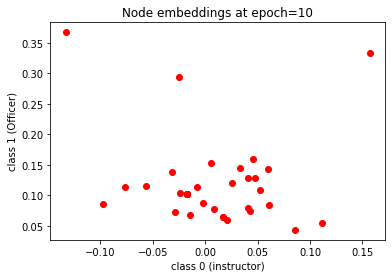

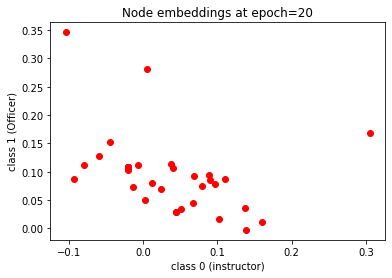

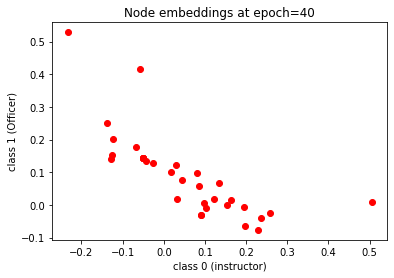

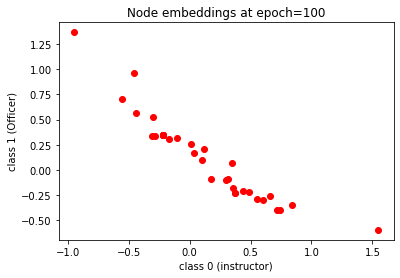

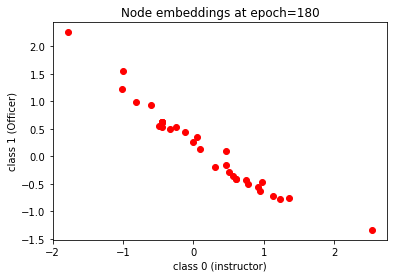

In [9]:
# Convert torch tensor to numpy arrays
for i in range(len(node_embeddings_at_timestamps)):
    node_embeddings_at_timestamps[i] = node_embeddings_at_timestamps[i].detach().numpy()

# Draw the scatter plots for 5 timestamps chosen(t=10,20,40,100,180)
for timestamp in range(len(node_embeddings_at_timestamps)):
    embedding = node_embeddings_at_timestamps[timestamp]
    # x and y are the points taken from final node embeddings for each node
    x = embedding[:,0]
    y = embedding[:,1]
    plt.scatter(x,y,color='r')
    plt.ylabel("class 1 (Officer)")
    plt.xlabel("class 0 (instructor)")
    if timestamp==0:
        plt.title("Node embeddings at epoch=10")
    if timestamp==1:
        plt.title("Node embeddings at epoch=20")
    if timestamp==2:
        plt.title("Node embeddings at epoch=40")
    if timestamp==3:
        plt.title("Node embeddings at epoch=100")
    if timestamp==4:
        plt.title("Node embeddings at epoch=180")
    plt.show()